# Demonstration and unit-testing `ri_ci` for Matlab

This file was tested on Matlab version 2019b, using the Jupyter `matlab_kernel`.

###  Matlab preliminaries

In [1]:
rng('default'); % set seed for replicability
addpath('../m'); % assumes we are in the /demo/ folder as pwd

In [2]:
%  Parameters of the simulation
N = 1000; % number of observations
R = 500 ; % number of alternative permutations of the treatment assignment to be used
tau = 1 ; % treatment effect

In [3]:
%  Generate data 
x = randn(N,1);
y0 = x + randn(N,1);
y1 = y0 + tau;
t = (rand(N,1) >= 0.5 ) ; % treatment status
y = y0 + t.*(y1 - y0) ; % switching regression
T0 = (rand(N,R) >= 0.5) ; % set of potential randomizations
DATA = array2table([y,t,x] , 'VariableNames',{'y','t','x'});

##  Testing specific sharp nulls

###  Testing null that $\tau_0 = 0$


ans =

    '__RESULTS OF ANALYTICAL MODEL:__'


lm = 


Linear regression model:
    y ~ 1 + t

Estimated Coefficients:
                   Estimate       SE        tStat       pValue  
                   ________    ________    _______    __________

    (Intercept)    0.016088    0.064268    0.25032       0.80239
    t               0.97731    0.089038     10.976    1.5259e-26


Number of observations: 1000, Error degrees of freedom: 998
Root Mean Squared Error: 1.41
R-squared: 0.108,  Adjusted R-Squared: 0.107
F-statistic vs. constant model: 120, p-value = 1.53e-26

ans =

    'The p-value from Randomization Inference for the hypothesis that tau = 0.00 is 0.00'




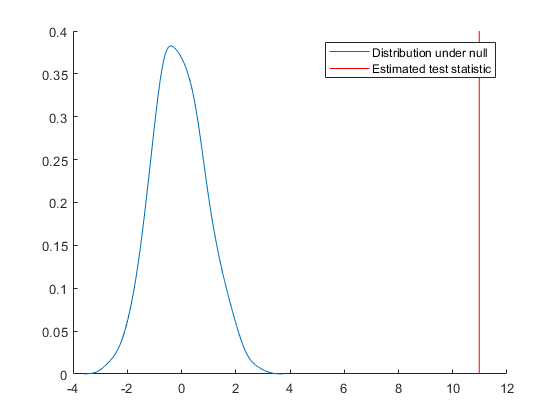

In [4]:
clear ri_ci
tau0 = 0;
[pval t1 t0] = ri_ci(DATA,{'y'},{'t'},tau0, T0, R ,'ShowMainEstimates',true);
%scatter(y0,y0star) % confirm this recovers the true y0

figure(1)
clf
hax = axes;
hold on
ksdensity(t0) % distribution of test statistic under the null.
line([t1 t1],get(hax,'YLim'),'Color','red'); % [0 1])
legend('Distribution under null','Estimated test statistic')
hold off

Illustrating one-sided versions of this hypothesis:

In [5]:
clear ri_ci
leftprob = ri_ci(DATA,{'y'},{'t'},0, T0, 100,'TestSide','lefttail')
rightprob = ri_ci(DATA,{'y'},{'t'},0, T0, 100,'TestSide','righttail')


leftprob =

     0


rightprob =

     0




###  Testing sharp nulls of non-zero treatment effects (e.g., $\tau_0=1$)

_Note:_  Model displays primary estimates that are the basis of analytic standard errors; p-values in that table correspond to test that $\tau_0=0$.

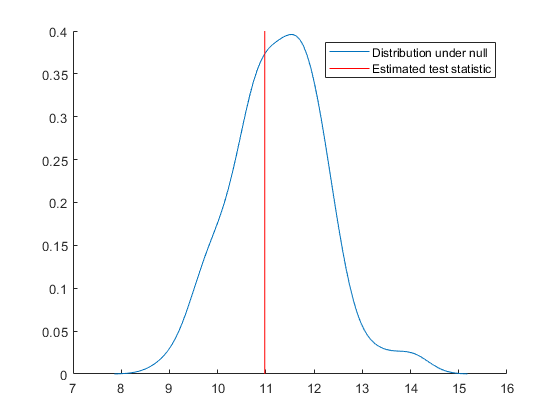

In [6]:
clear ri_ci
tau0 = 1;
[pval t1 t0] = ri_ci(DATA,{'y'},{'t'},tau0, T0, 100);
%scatter(y0,y0star) % confirm this recovers the true y0

figure(2)
clf
hax = axes;
hold on
ksdensity(t0) % distribution of test statistic under the null.
line([t1 t1],get(hax,'YLim'),'Color','red'); % [0 1])
legend('Distribution under null','Estimated test statistic')
hold off

## Finding 95% confidence interval

In [7]:
clear ri_ci
tau0 = 0;
tic
[pval ,~,~,~,CI ,Q_UB, Q_LB ] = ri_ci(DATA,{'y'},{'t'},tau0, T0, R ,'FindCI',true);
toc

pval
CI 

Elapsed time is 123.084316 seconds.

pval =

     0


CI =

    0.7881    1.1682




In [8]:
[Q_UB, Q_LB]


ans =

    1.8499         0    0.1047         0
    1.4136         0    0.5410         0
    1.1955    0.0040    0.7592    0.0120
    1.0864    0.2440    0.8682    0.1800
    1.1409    0.0440    0.8137    0.0600
    1.1682    0.0280    0.7864    0.0240
    1.1818    0.0120    0.8001    0.0360
    1.1750    0.0240    0.7933    0.0320
    1.1716    0.0240    0.7898    0.0280
    1.1699    0.0240    0.7881    0.0280




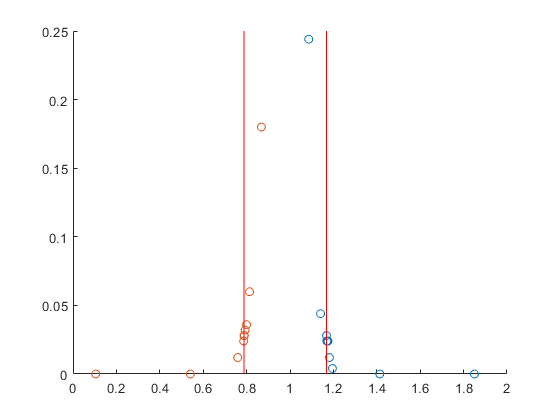

In [9]:
figure(3)
clf
hax = axes;
hold on
scatter(Q_UB(:,1),Q_UB(:,2))
scatter(Q_LB(:,1),Q_LB(:,2))
line([CI(1) CI(1)],get(hax,'YLim'),'Color','red'); % [0 1])
line([CI(2) CI(2)],get(hax,'YLim'),'Color','red'); % [0 1])
hold off

## Functionality with estimation commands other than `lm()`

When using estimation commands other than `lm()`, we will use 10 times the asymptotic confidence interval for OLS, assuming independent and homoskedastic errors, to define the search region, if the search region is not supplied by the user.

###  Use with `rereg()` for random effects.

To demonstrate how this can be used with `rereg()`, we will simluate data with cluster-randomized assignment.  Let there be groups $g=1,\ldots,G$, with $G=200$, and observations indexed by $\{ig\}$ with $n=5$ observations per group.

Let $y_{0,ig} = e_{0,g} + e_{0,ig}$ with each error term $\sim N(0,1)$.

Let the treatment effect, $\tau=1$, and $y_{1,ig}=y_{0,ig}+\tau$ for all $i,g$.

Observed outcomes are given by the _switching regression_ $y_{ig} = y_{0,ig} + (y_{1,ig} - y_{0,ig})  t_{ig} = y_{0,ig} + \tau t_{ig}$

In [18]:
tau = 1 ;
G=200;
n=5;
t = (rand(G,1) >= 0.5 ) ; % treatment status
T0 = (rand(G,R) >= 0.5) ; % set of potential randomizations
e_0g = randn(G,1) ; % error term at cluster level
g = [1:G]';  % group index

%  Expand all group-level datasets to the individual level
t = kron(t,ones(n,1));
T0 = kron(T0,ones(n,1));
e_0g = kron(e_0g,ones(n,1));
g = kron(g,ones(n,1));

%  remainder of DGP at individual level
e_0i = randn(G*n,1);
y0 = e_0g + e_0i ;
y1 = y0 + tau ;
y = y0 + tau * (y1 - y0);

**Demonstrating use of `rereg()`**

In [23]:
clear rereg
size(y)
size(t)
size(g)
beta_re = rereg(y,t,g)


ans =

        1000           1


ans =

        1000           1


ans =

        1000           1




### Use with `kstest()` for Kolmogorov-Smirnov test statistic

In [24]:
%show_gui